# Модель машиннго обучения - RandomForestRegressor()!!!

In [1]:
# загружаем библиотеки
import pandas as pd # работа с данными / python data analysis library
import numpy as np # работа с числовыми данными / python numerical computing library
import seaborn as sns # визуализация данных / python data visualization library
import matplotlib.pyplot as plt # визуализация данных / python data visualization library

from sklearn.ensemble import RandomForestRegressor # модель случайного леса / random forest

from sklearn.metrics import mean_absolute_error # метрика средняя абсолютная ошибка / mean absolute error
from sklearn.metrics import mean_squared_error # метрика средняя квадратичная ошибка / mean squared error
from sklearn.metrics import mean_absolute_percentage_error # метрика средняя абсолютная процентная ошибка / mean absolute percentage error
from sklearn.metrics import f1_score # метрика f1

from sklearn.model_selection import train_test_split # разделение выборки на обучающую и тестовую / train_test_split
from sklearn.feature_selection import SelectKBest, f_regression # алгоритм для выбора признаков с наивысшими оценками в модели машинного обучения на основе статистических тестов / f-regression одномерный тест линейной регрессии  
from sklearn.preprocessing import MinMaxScaler # алгоритм стандартизации данных / MinMaxScaler

from joblib import dump, load # сохранение и загрузка модели 

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING) # отключаем вывод промежуточных итогов вычислений

# отключаем предупреждения
import warnings 
warnings.filterwarnings("ignore")

# фиксируем RANDOM_SEED, для воспроизводимости кода.
RANDOM_SEED = 369


Тренировочная выборка:
     RMSE: 0.14
     MAE: 0.08
     MAPE: 0.63%
Валидационная выборка:
     RMSE: 0.35
     MAE: 0.21
     MAPE: 1.65%
Тестовая выборка:
     RMSE: 0.35
     MAE: 0.21
     MAPE: 1.66%



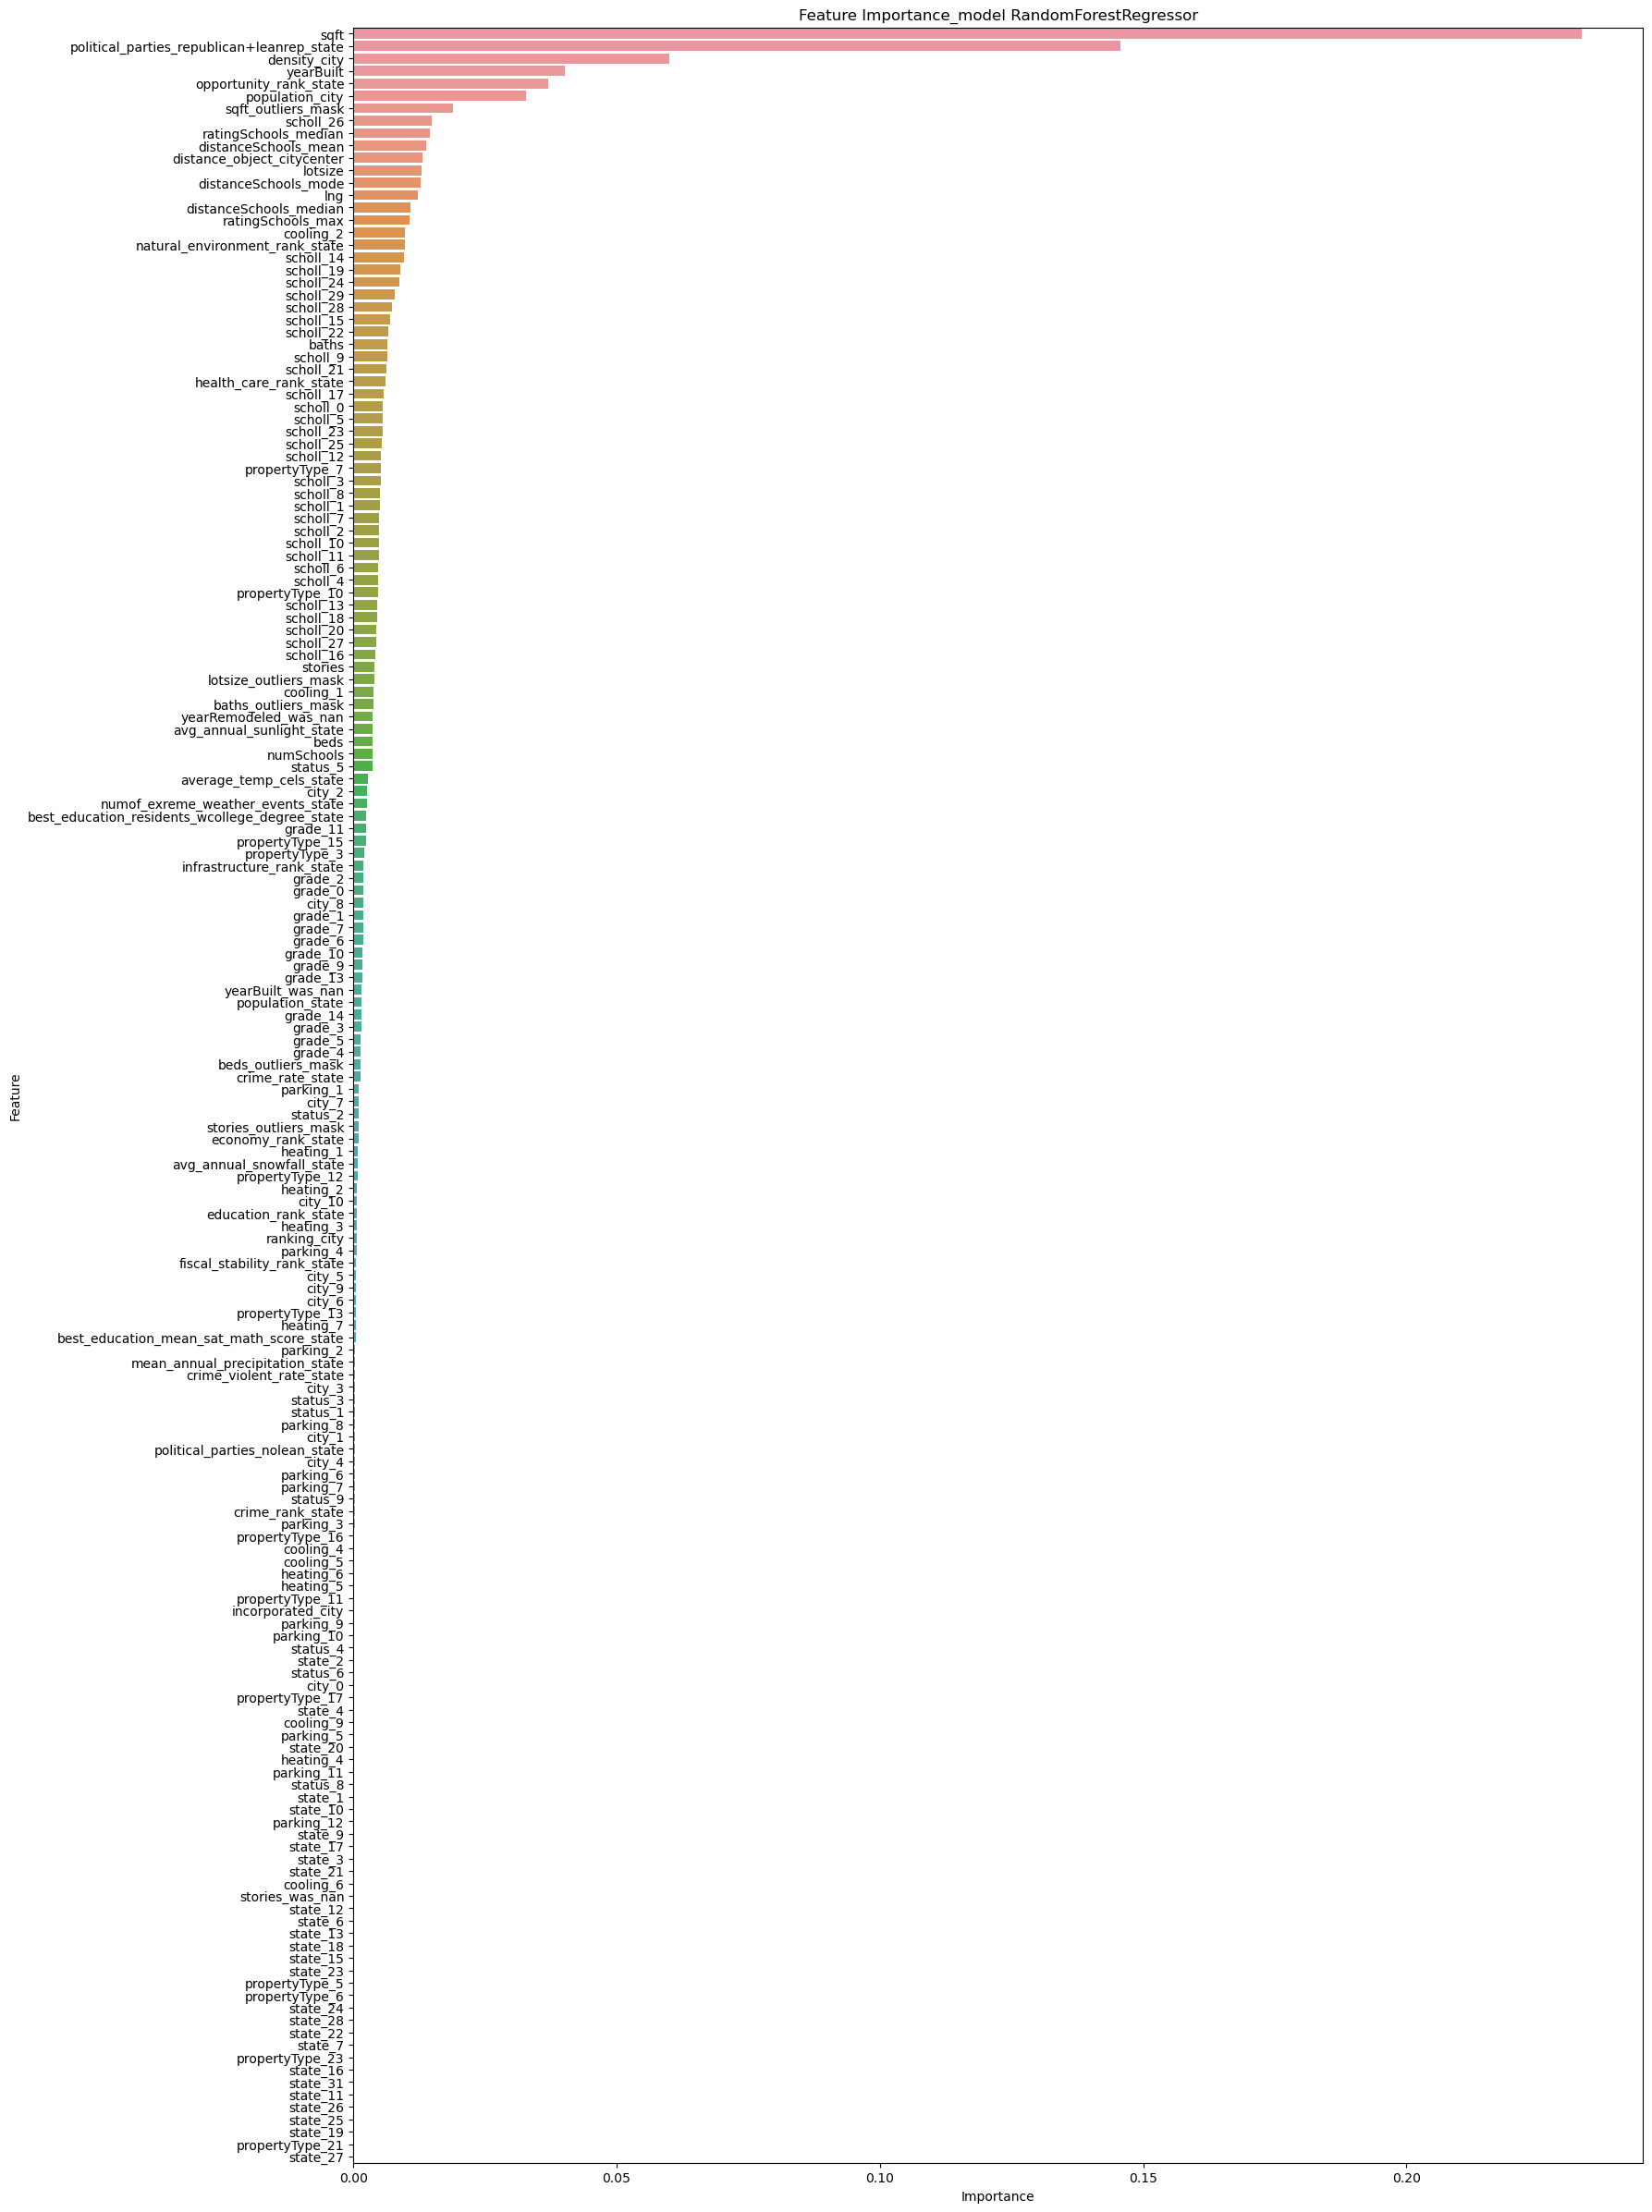

CPU times: user 25min 3s, sys: 7.56 s, total: 25min 10s
Wall time: 25min 32s


In [2]:
%%time
# загружаем данные
data_rfr = pd.read_csv("data/data_final.csv", sep=",")

# создаем матрицу наблюдений и вектор правильных ответов
X = data_rfr.drop(columns="target", axis=1)
y = data_rfr["target"]

# производим разделение выборки на тренировочную, валидационную и тестовую
X_train, X_validtest, y_train, y_validtest = train_test_split(X, y, train_size=0.8, random_state=RANDOM_SEED)
X_valid, X_test, y_valid, y_test = train_test_split(X_validtest, y_validtest, test_size=0.5, random_state=RANDOM_SEED)

# формируем лист признаков для графика
feature_names = X_train.columns

# производим нормализацию данных
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(X_train)
X_train = min_max_scaler.transform(X_train)
X_valid = min_max_scaler.transform(X_valid)
X_test = min_max_scaler.transform(X_test)

# инициализируем и обучаем модель
model_rfr = RandomForestRegressor(random_state=RANDOM_SEED)
model_rfr.fit(X_train, y_train)
# формируем предсказания
y_train_predict_rfr = model_rfr.predict(X_train)
y_valid_predict_rfr = model_rfr.predict(X_valid)
y_test_predict_rfr = model_rfr.predict(X_test)

# выводим метрики оценки качества
print()
print("Тренировочная выборка:")
print("     RMSE: {:.2f}".format(np.sqrt(mean_squared_error(y_train, y_train_predict_rfr))))
print("     MAE: {:.2f}".format(mean_absolute_error(y_train, y_train_predict_rfr)))
print("     MAPE: {:.2f}%".format(mean_absolute_percentage_error(y_train, y_train_predict_rfr)*100))
print("Валидационная выборка:")
print("     RMSE: {:.2f}".format(np.sqrt(mean_squared_error(y_valid, y_valid_predict_rfr))))
print("     MAE: {:.2f}".format(mean_absolute_error(y_valid, y_valid_predict_rfr)))
print("     MAPE: {:.2f}%".format(mean_absolute_percentage_error(y_valid, y_valid_predict_rfr)*100))
print("Тестовая выборка:")
print("     RMSE: {:.2f}".format(np.sqrt(mean_squared_error(y_test, y_test_predict_rfr))))
print("     MAE: {:.2f}".format(mean_absolute_error(y_test, y_test_predict_rfr)))
print("     MAPE: {:.2f}%".format(mean_absolute_percentage_error(y_test, y_test_predict_rfr)*100))
print()

# выводим график важности признаков
feature_importance = model_rfr.feature_importances_
feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importance})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)
plt.figure(figsize=(18, 30))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df)
plt.title("Feature Importance_model RandomForestRegressor")
plt.show()

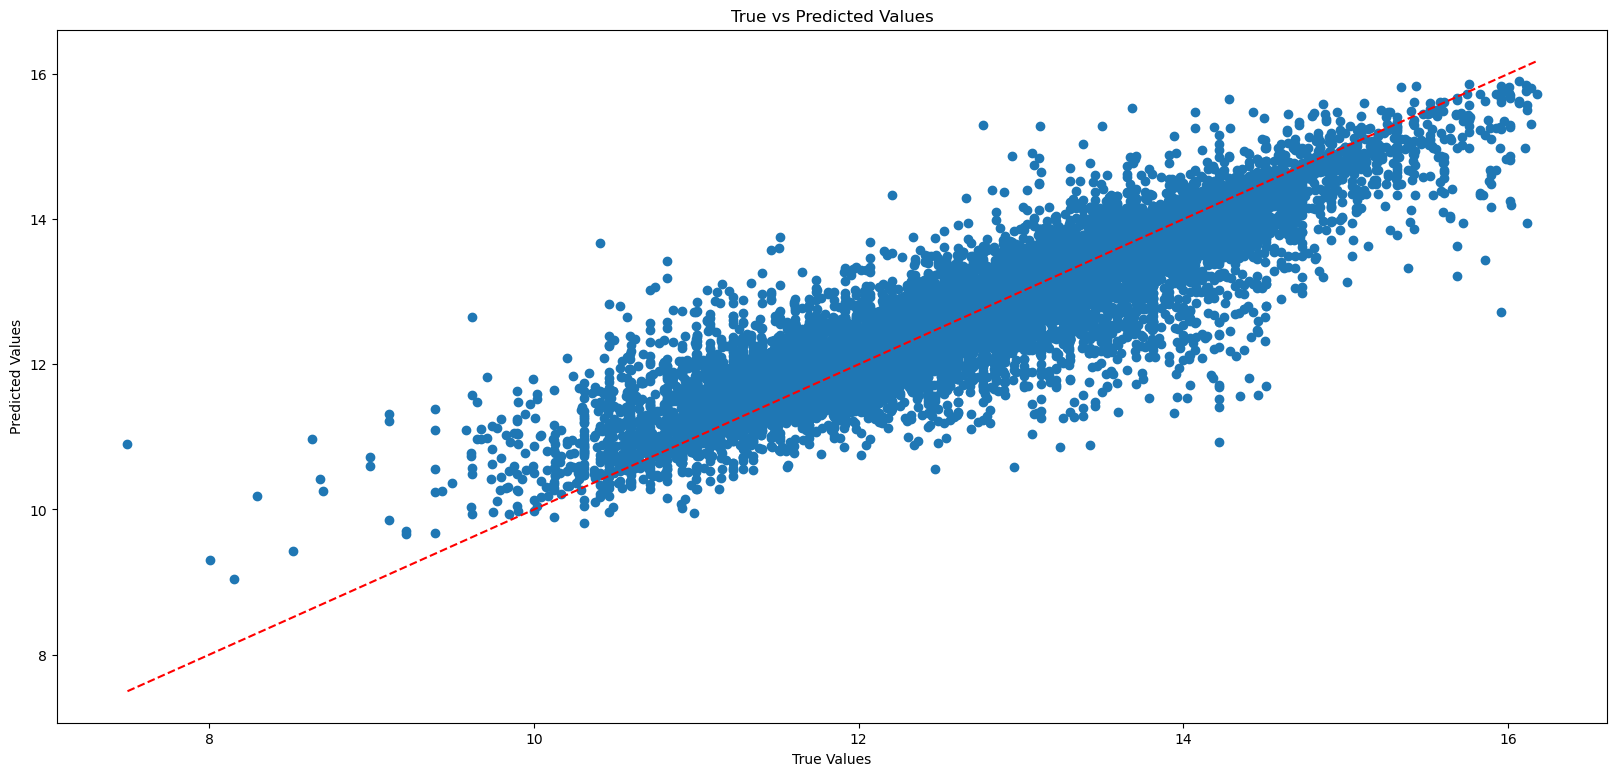

In [3]:
# график предсказанных значений против истинных значений на тестовой выборке
plt.figure(figsize=(20, 9))
plt.scatter(y_test, y_test_predict_rfr)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle="--", color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values")
plt.show()

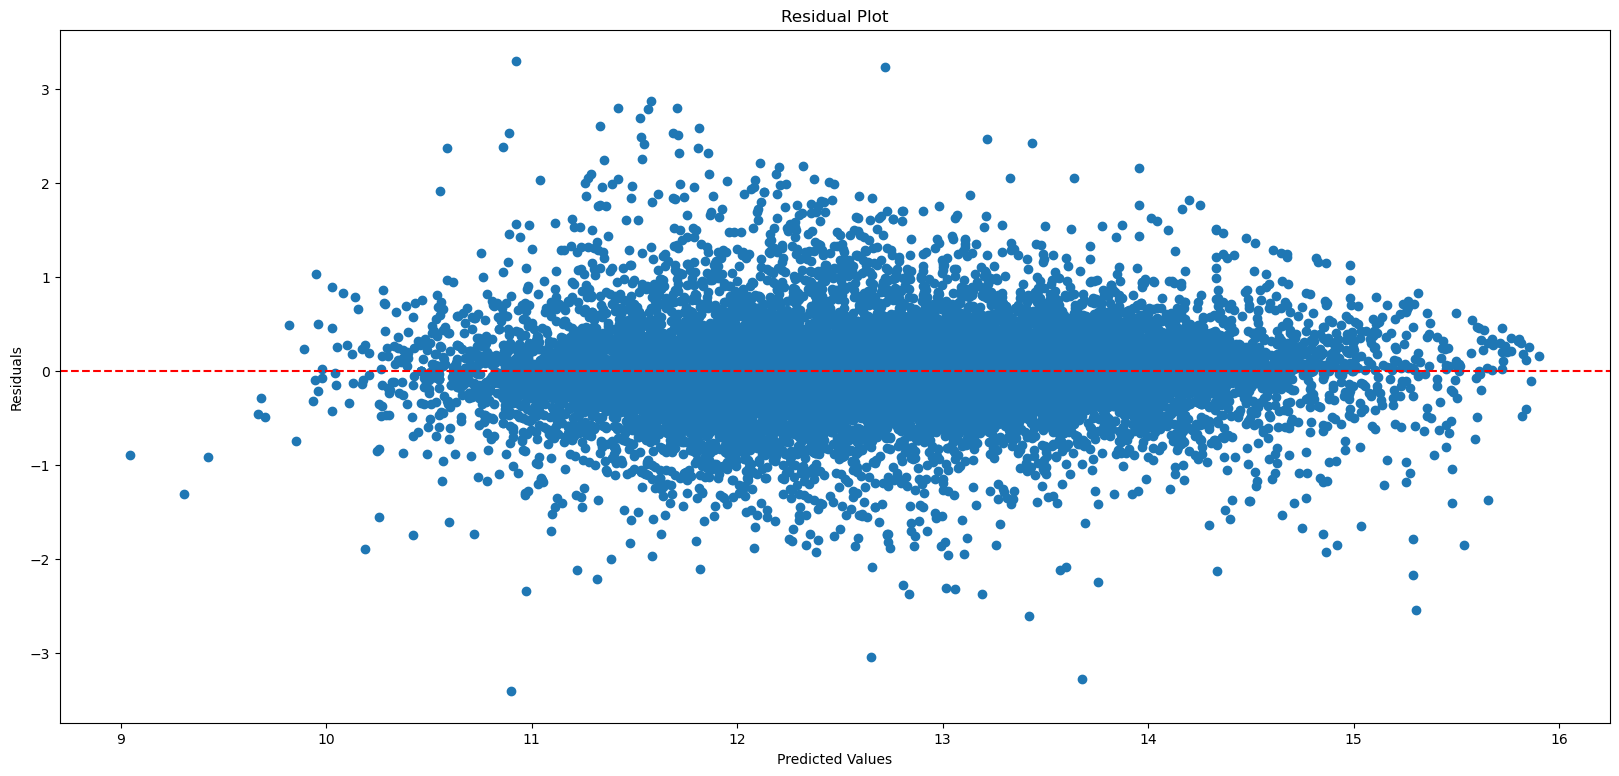

In [4]:
# график остатков на тестовой выборке
residuals = y_test - y_test_predict_rfr
plt.figure(figsize=(20, 9))
plt.scatter(y_test_predict_rfr, residuals)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

In [5]:
# cохраняем модель в файл
dump(model_rfr, "model/model_RandomForestRegressor.joblib")

['model/model_RandomForestRegressor.joblib']

#### Optimization model - **OPTUNA** - Подбор гиперпараметров

In [6]:
# %%time
# фломируем модель optuna для подбора гиперпараметров
def optuna_objective(trial):
    # задаем диапазон значений гиперпараметров
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000), # количество деревьев в случайном лесу
        "max_depth": trial.suggest_int("max_depth", 2, 30), # глубина деревьев
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20), # определяет минимальное количество обработанных точек, необходимых для разделения узла дерева
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10), # определяет минимальное количество образцов (точек данных), которые должны находиться в листовом узле дерева
        #"max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
        #"criterion": trial.suggest_categorical("criterion", ["poisson", "friedman_mse", "squared_error"]),
        #"min_impurity_decrease": trial.suggest_float("min_impurity_decrease", 0.0, 0.5, step=0.1),
        #"oob_score": trial.suggest_categorical("oob_score", [True, False]),
        #"min_weight_fraction_leaf": trial.suggest_float("min_weight_fraction_leaf", 0.0, 0.5, step=0.1)
    }

    # инициализируем и обучаем модель
    optuna_rfr = RandomForestRegressor(**param, random_state=RANDOM_SEED)
    optuna_rfr.fit(X_train, y_train)

    # формируем предсказания на валидных данных
    y_pred = optuna_rfr.predict(X_valid)
    mae = mean_absolute_error(y_valid, y_pred)

    return mae

# создаем и оптимизируем исследование с MedianPruner
study = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner())
study.optimize(optuna_objective, n_trials=20, show_progress_bar=True, n_jobs=-1)

# выводим лучшие параметры
best_params = study.best_trial.params
print(f"Лучшие параметры: {best_params}")

  0%|          | 0/20 [00:00<?, ?it/s]

Лучшие параметры: {'n_estimators': 100, 'max_depth': 27, 'min_samples_split': 12, 'min_samples_leaf': 4}


In [7]:
# %%time
# инициализируем и обучаем модель с подобранными параметрами
model_rfr_optuna = RandomForestRegressor(**best_params, random_state=RANDOM_SEED)
model_rfr_optuna.fit(X_train, y_train)

# формируем предсказания
y_train_predict_rfr_optuna = model_rfr_optuna.predict(X_train)
y_valid_predict_rfr_optuna = model_rfr_optuna.predict(X_valid)
y_test_predict_rfr_optuna = model_rfr_optuna.predict(X_test)

# выводим метрики оценки качества
print()
print("Тренировочная выборка:")
print("     RMSE: {:.2f}".format(np.sqrt(mean_squared_error(y_train, y_train_predict_rfr_optuna))))
print("     MAE: {:.2f}".format(mean_absolute_error(y_train, y_train_predict_rfr_optuna)))
print("     MAPE: {:.2f}%".format(mean_absolute_percentage_error(y_train, y_train_predict_rfr_optuna)*100))
print("Валидационная выборка:")
print("     RMSE: {:.2f}".format(np.sqrt(mean_squared_error(y_valid, y_valid_predict_rfr_optuna))))
print("     MAE: {:.2f}".format(mean_absolute_error(y_valid, y_valid_predict_rfr_optuna)))
print("     MAPE: {:.2f}%".format(mean_absolute_percentage_error(y_valid, y_valid_predict_rfr_optuna)*100))
print("Тестовая выборка:")
print("     RMSE: {:.2f}".format(np.sqrt(mean_squared_error(y_test, y_test_predict_rfr_optuna))))
print("     MAE: {:.2f}".format(mean_absolute_error(y_test, y_test_predict_rfr_optuna)))
print("     MAPE: {:.2f}%".format(mean_absolute_percentage_error(y_test, y_test_predict_rfr_optuna)*100))
print()


Тренировочная выборка:
     RMSE: 0.24
     MAE: 0.14
     MAPE: 1.13%
Валидационная выборка:
     RMSE: 0.35
     MAE: 0.22
     MAPE: 1.74%
Тестовая выборка:
     RMSE: 0.35
     MAE: 0.22
     MAPE: 1.75%



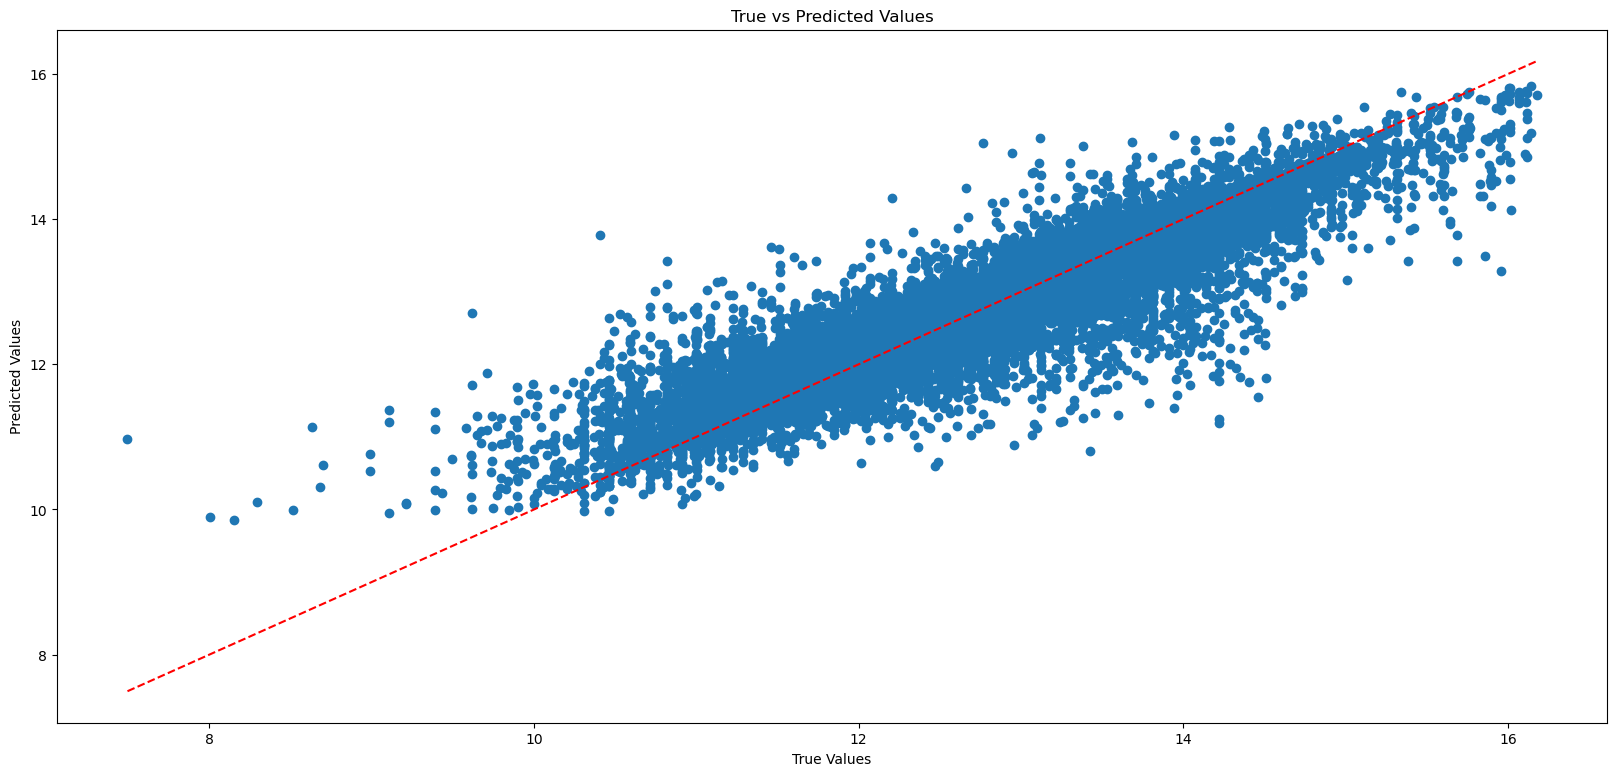

In [8]:
# график предсказанных значений против истинных значений на тестовой выборки
plt.figure(figsize=(20, 9))
plt.scatter(y_test, y_test_predict_rfr_optuna)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle="--", color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values")
plt.show()

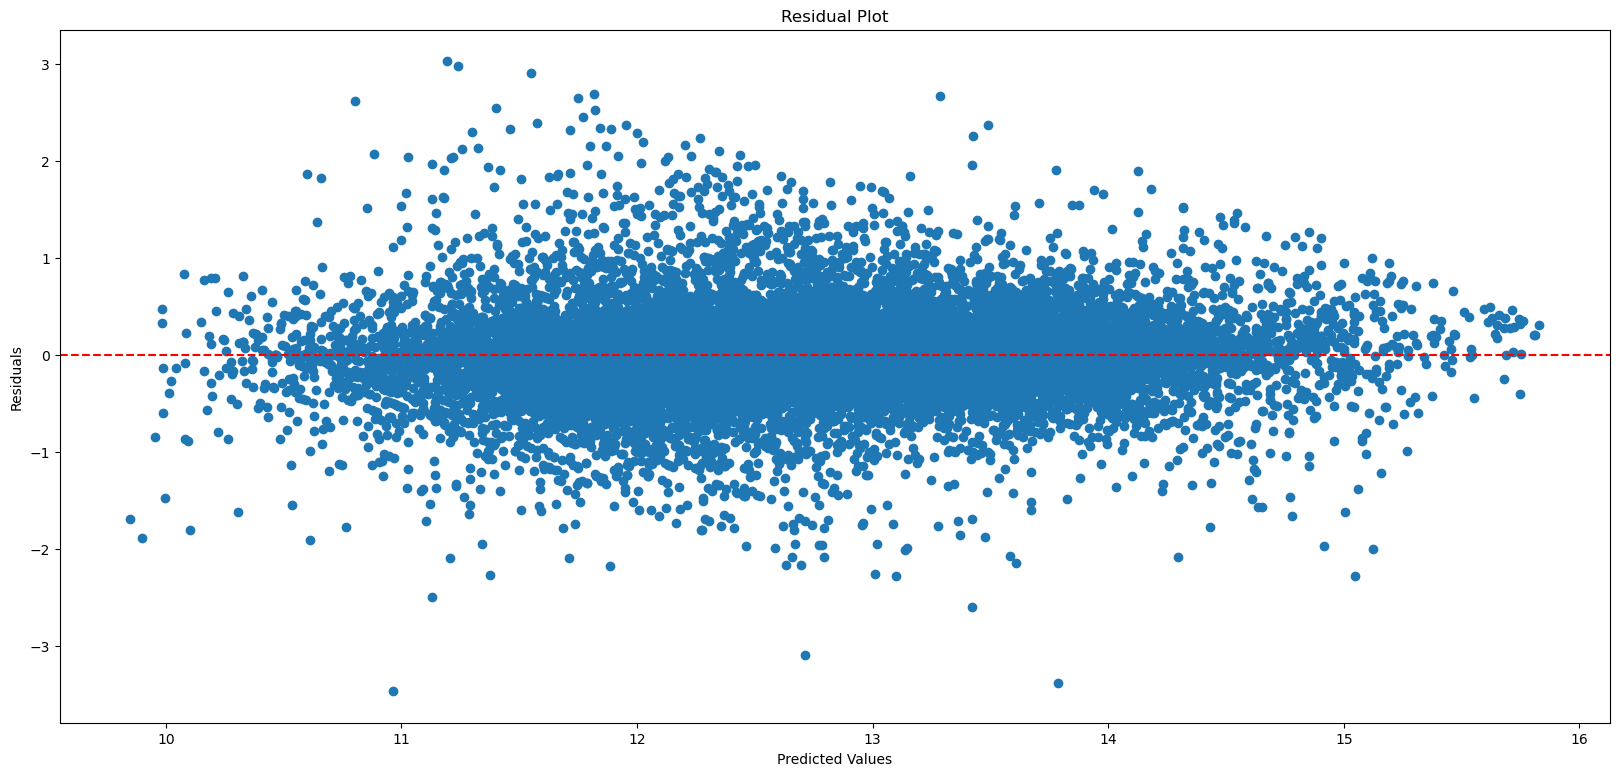

In [9]:
# график остатков на тестовой выборки
residuals = y_test - y_test_predict_rfr_optuna
plt.figure(figsize=(20, 9))
plt.scatter(y_test_predict_rfr_optuna, residuals)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

In [10]:
# формируем и выводим график истории оптимизации
optuna.visualization.plot_optimization_history(study, target_name="mae")

In [11]:
# формируем и выводим график важности гиперпараметров
optuna.visualization.plot_param_importances(study, target_name="mae")

In [12]:
# # визуализация контуров гиперпараметров
# optuna.visualization.plot_contour(study, params=["min_weight_fraction_leaf", "min_samples_split"], target_name="mae")

In [13]:
# визуализация среза
optuna.visualization.plot_slice(study, target_name="mae")

In [14]:
# # визуализация промежуточных значений (полезна, если вы используете промежуточные значения во время оптимизации)
# optuna.visualization.plot_intermediate_values(study)

In [15]:
# визуализация прогресса оптимизации для параллельной координатной плоскости
optuna.visualization.plot_parallel_coordinate(study, target_name="mae")

In [16]:
# визуализация соотношения гиперпараметров к целевой метрике
optuna.visualization.plot_edf(study, target_name="mae")

In [17]:
# cохраняем модель в файл
dump(model_rfr_optuna, "model/model_RandomForestRegressorOptuna.joblib")

['model/model_RandomForestRegressorOptuna.joblib']

#### Optimization library **Hyperopt** - подбор гиперпараметров модели

In [18]:
# %%time
# формируем модель Hyperopt для подбора гиперпараметров
def hyperopt_objective(params):
    # приводим параметры к целым числам, где это необходимо
    params['n_estimators'] = int(params['n_estimators'])
    params['max_depth'] = int(params['max_depth'])
    params['min_samples_split'] = int(params['min_samples_split'])
    params['min_samples_leaf'] = int(params['min_samples_leaf'])

    # Инициализируем и обучаем модель
    hyperopt_rfr = RandomForestRegressor(**params, random_state=RANDOM_SEED)
    hyperopt_rfr.fit(X_train, y_train)

    # Формируем предсказания на валидных данных
    y_pred = hyperopt_rfr.predict(X_valid)
    mae = mean_absolute_error(y_valid, y_pred)

    return {'loss': mae, 'status': STATUS_OK}

# задаем диапазон значений гиперпараметров
space = {
    "n_estimators": hp.quniform("n_estimators", 10, 1000, 1),
    "max_depth": hp.quniform("max_depth", 2, 30, 1),
    "min_samples_split": hp.quniform("min_samples_split", 2, 20, 1),
    "min_samples_leaf": hp.quniform("min_samples_leaf", 1, 10, 1),
    # "min_impurity_decrease": hp.uniform("min_impurity_decrease", 0.0, 0.5),
    # "min_weight_fraction_leaf": hp.uniform("min_weight_fraction_leaf", 0.0, 0.5)
}

# создаем объект Trials для хранения информации о процессе
trials = Trials()

# запускаем оптимизацию
best = fmin(
    fn=hyperopt_objective,
    space=space,
    algo=tpe.suggest,
    max_evals=15,  # количество итераций
    trials=trials
)

# приводим "n_estimators" и "max_depth" к целым числам, так как Hyperopt возвращает float
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['min_samples_split'] = int(best['min_samples_split'])
best['min_samples_leaf'] = int(best['min_samples_leaf'])

print(f"Лучшие параметры: {best}")

100%|██████████| 15/15 [19:02:37<00:00, 4570.49s/trial, best loss: 0.2109931194060939]  
Лучшие параметры: {'max_depth': 28, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 734}


In [19]:
# %%time
# продолжим подбор параметров, увеличиваем max_evals(должен быть строго больше, чем на предыдуших итерациях) и используем старый trials
best=fmin(hyperopt_objective, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(RANDOM_SEED) # фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 20/20 [7:37:29<00:00, 5489.88s/trial, best loss: 0.2109931194060939]  
Наилучшие значения гиперпараметров {'max_depth': 28.0, 'min_samples_leaf': 2.0, 'min_samples_split': 6.0, 'n_estimators': 734.0}


In [20]:
# %%time
# приводим параметры к целым числам, так как Hyperopt возвращает float
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['min_samples_split'] = int(best['min_samples_split'])
best['min_samples_leaf'] = int(best['min_samples_leaf'])

# инициализируем и обучаем модель с подобранными параметрами
model_rfr_hyperopt = RandomForestRegressor(**best, random_state=RANDOM_SEED)
model_rfr_hyperopt.fit(X_train, y_train)

# формируем предсказания
y_train_predict_rfr_best = model_rfr_hyperopt.predict(X_train)
y_valid_predict_rfr_best = model_rfr_hyperopt.predict(X_valid)
y_test_predict_rfr_best = model_rfr_hyperopt.predict(X_test)

# выводим метрики оценки качества
print()
print("Тренировочная выборка:")
print("     RMSE: {:.2f}".format(np.sqrt(mean_squared_error(y_train, y_train_predict_rfr_best))))
print("     MAE: {:.2f}".format(mean_absolute_error(y_train, y_train_predict_rfr_best)))
print("     MAPE: {:.2f}%".format(mean_absolute_percentage_error(y_train, y_train_predict_rfr_best)*100))
print("Валидационная выборка:")
print("     RMSE: {:.2f}".format(np.sqrt(mean_squared_error(y_valid, y_valid_predict_rfr_best))))
print("     MAE: {:.2f}".format(mean_absolute_error(y_valid, y_valid_predict_rfr_best)))
print("     MAPE: {:.2f}%".format(mean_absolute_percentage_error(y_valid, y_valid_predict_rfr_best)*100))
print("Тестовая выборка:")
print("     RMSE: {:.2f}".format(np.sqrt(mean_squared_error(y_test, y_test_predict_rfr_best))))
print("     MAE: {:.2f}".format(mean_absolute_error(y_test, y_test_predict_rfr_best)))
print("     MAPE: {:.2f}%".format(mean_absolute_percentage_error(y_test, y_test_predict_rfr_best)*100))
print()


Тренировочная выборка:
     RMSE: 0.19
     MAE: 0.11
     MAPE: 0.85%
Валидационная выборка:
     RMSE: 0.35
     MAE: 0.21
     MAPE: 1.67%
Тестовая выборка:
     RMSE: 0.35
     MAE: 0.21
     MAPE: 1.68%



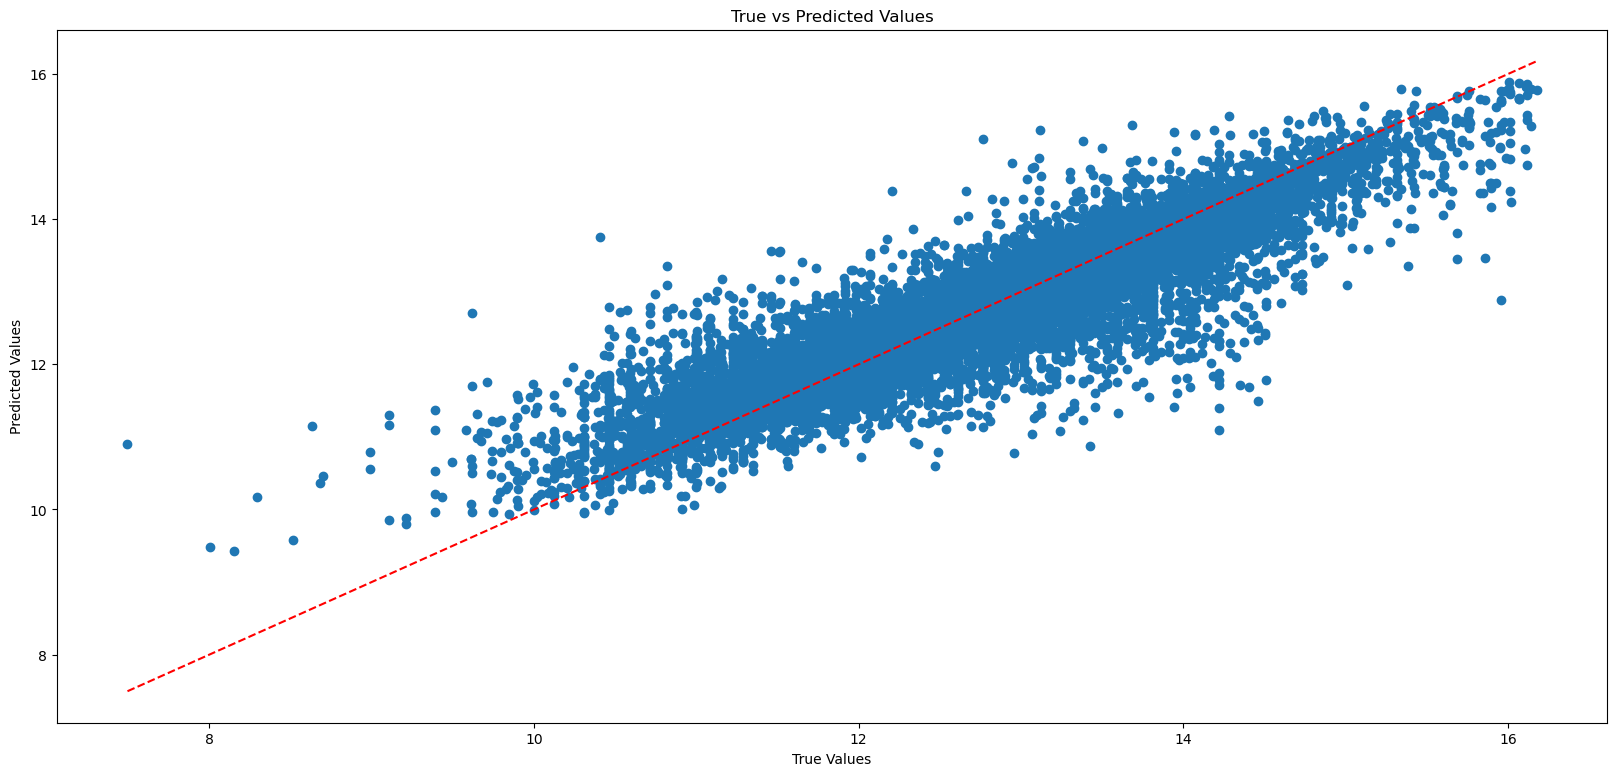

In [21]:
# график предсказанных значений против истинных значений для тестовой выборки
plt.figure(figsize=(20, 9))
plt.scatter(y_test, y_test_predict_rfr_best)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle="--", color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values")
plt.show()

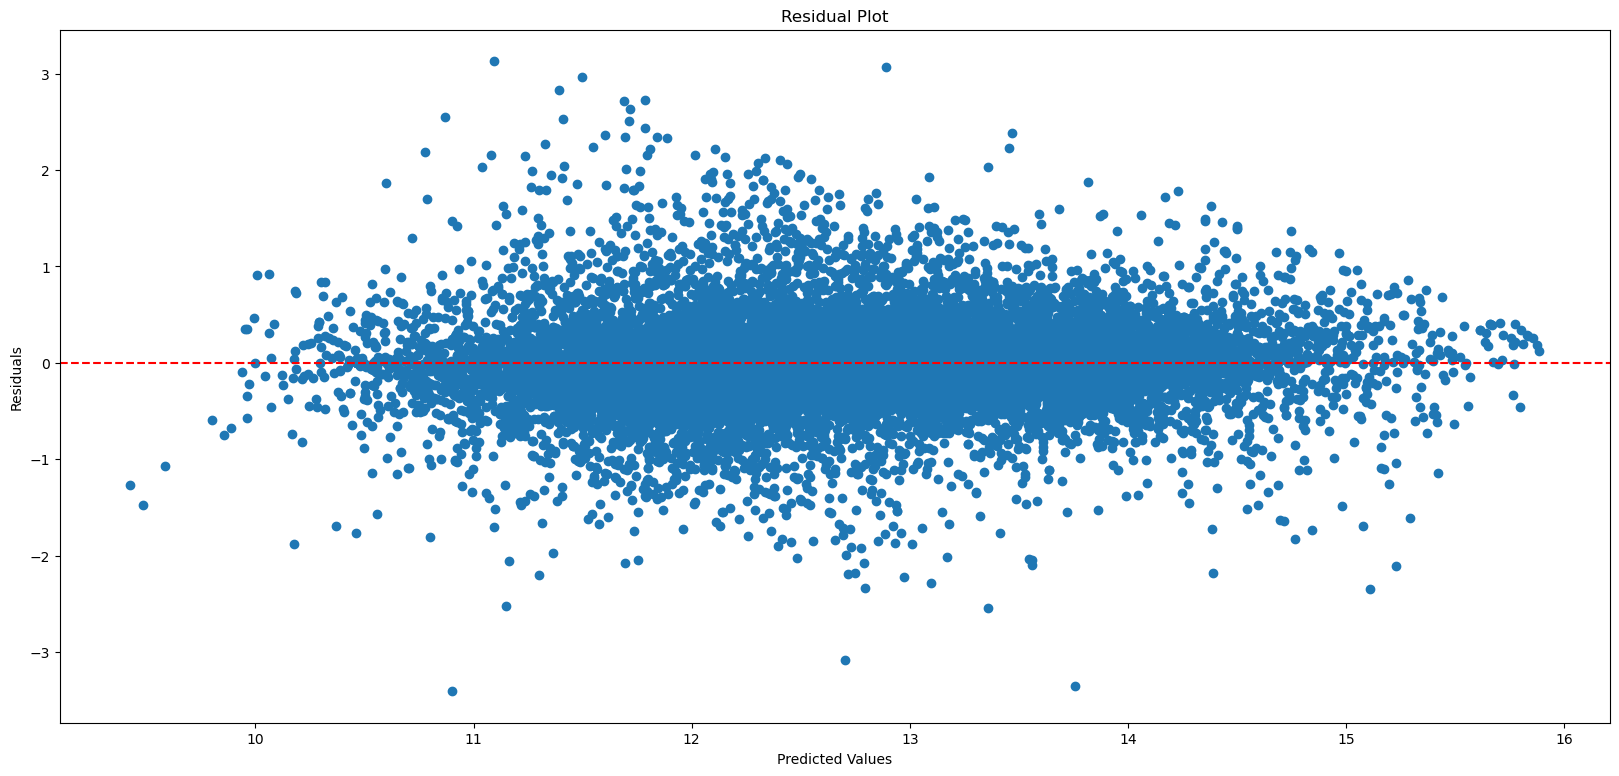

In [22]:
# график остатков для тестовой выборки
residuals = y_test - y_test_predict_rfr_best
plt.figure(figsize=(20, 9))
plt.scatter(y_test_predict_rfr_best, residuals)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

array([<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >], dtype=object)

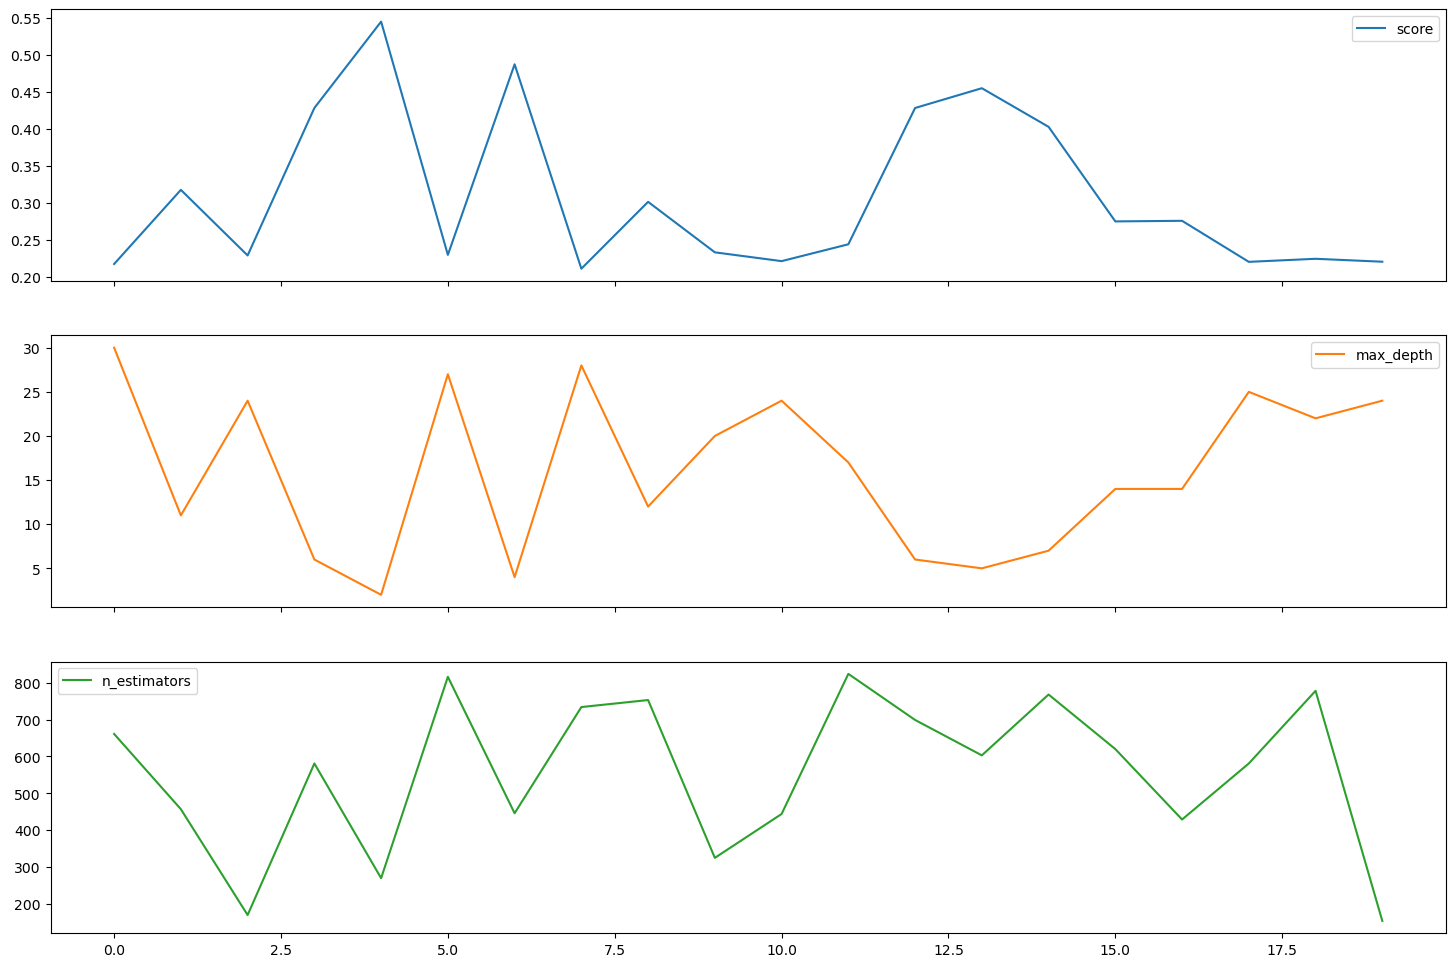

In [23]:
# формируем и выводим график, как менялась точность при различных гиперпараметрах
tpe_results=np.array([[x["result"]["loss"],
                      x["misc"]["vals"]["max_depth"][0],
                      x["misc"]["vals"]["n_estimators"][0]] for x in trials.trials])

tpe_results_df=pd.DataFrame(tpe_results,
                           columns=['score', 'max_depth', 'n_estimators'])
# тепловая карта в данном случае не наглядна, применяем линейный график
tpe_results_df.plot(subplots=True,figsize=(18, 12))

In [24]:
# cохраняем модель в файл c подобранными гиперпараметрами
dump(model_rfr_hyperopt, "model/model_RandomForestRegressorHyperopt.joblib")

['model/model_RandomForestRegressorHyperopt.joblib']

In [25]:
# в данную переменную буду сохранять результаты моделей [RSME, MAE, MAPE и название алгоритма]
results = []

# описываем функцию для оценки модели, а также для сохранения значений метрик и последующего использования
def results_model(model, X_train, y_train, X_valid, y_valid, X_test, y_test, model_name, results):
  """Функция для вывода результатов score для train, valid и test, а также для сохранения этих значений для последующего использования.
    
  Аргументы:
    model (model): обученная модель, которую необходимо оценить;
    model_name (string): название используемой модели.
  """
  model_result = []
  # предсказания и оценка для тренировочных данных
  y_train = np.expm1(y_train)
  y_train_pred = np.expm1(model.predict(X_train))
  RMSE_train = np.sqrt(mean_squared_error(y_train, y_train_pred)).round(3)
  MAE_train = mean_absolute_error(y_train, y_train_pred).round(3)
  MAPE_train = (mean_absolute_percentage_error(y_train, y_train_pred) * 100).round(3)
  # вывод результатов для тренировочных данных
  # print(f"Тренировочная выборка:")
  # print(f"    RMSE: {RMSE_train:.3f}")
  # print(f"    MAE: {MAE_train:.3f}")
  # print(f"    MAPE: {MAPE_train:.2f}%")
  
  # предсказания и оценка для валидационных данных
  y_valid = np.expm1(y_valid)
  y_valid_pred = np.expm1(model.predict(X_valid))
  RMSE_valid = np.sqrt(mean_squared_error(y_valid, y_valid_pred)).round(3)
  MAE_valid = mean_absolute_error(y_valid, y_valid_pred).round(3)
  MAPE_valid = (mean_absolute_percentage_error(y_valid, y_valid_pred) * 100).round(3)
  # вывод результатов для валидационных данных
  # print(f"Валидная выборка:")
  # print(f"    RMSE: {RMSE_valid:.3f}")
  # print(f"    MAE: {MAE_valid:.3f}")
  # print(f"    MAPE: {MAPE_valid:.2f}%")
  
  # предсказания и оценка для тестовых данных
  y_test = np.expm1(y_test)
  y_test_pred = np.expm1(model.predict(X_test))
  RMSE_test = np.sqrt(mean_squared_error(y_test, y_test_pred)).round(3)
  MAE_test = mean_absolute_error(y_test, y_test_pred).round(3)
  MAPE_test = (mean_absolute_percentage_error(y_test, y_test_pred) * 100).round(3)
  # вывод результатов для тестовых данных
  # print(f"Тестовая выборка:")
  # print(f"    RMSE: {RMSE_test:.3f}")
  # print(f"    MAE: {MAE_test:.3f}")
  # print(f"    MAPE: {MAPE_test:.2f}%") 
  
  # сохранение результатов в список model_results
  results.append({
      "RMSE_train": RMSE_train, "MAE_train": MAE_train, "MAPE_train": MAPE_train,
      "RMSE_valid": RMSE_valid, "MAE_valid": MAE_valid, "MAPE_valid": MAPE_valid,
      "RMSE_test": RMSE_test, "MAE_test": MAE_test, "MAPE_test": MAPE_test, 
      "ML_model": model_name
    })
  
  # сохранение результатов в список model_results
  model_result.append({
      "RMSE_train": RMSE_train, "MAE_train": MAE_train, "MAPE_train": MAPE_train,
      "RMSE_valid": RMSE_valid, "MAE_valid": MAE_valid, "MAPE_valid": MAPE_valid,
      "RMSE_test": RMSE_test, "MAE_test": MAE_test, "MAPE_test": MAPE_test, 
      "ML_model": model_name
    })
  
  # создаем dataframe с результатами
  resultmodelScoreData = pd.DataFrame(model_result).set_index('ML_model').sort_values(by='MAPE_test', ascending=True)
  # выводим сводную информацию 
  display(resultmodelScoreData.sort_values(by="MAE_test", ascending=True).round(2))

In [26]:
# делаем предсказания на тренировочной, валидной и тестовой выборках и выводим результат
print("Модель RandomForestRegressor:")
results_model(model_rfr, X_train, y_train, X_valid, y_valid, X_test, y_test, "RandomForestRegressor", results)
print()
print("Модель RandomForestRegressorOptuna - с подбором гиперпараметров (библиотека Optuna):")
results_model(model_rfr_optuna, X_train, y_train, X_valid, y_valid, X_test, y_test, "RandomForestRegressorOptuna", results)
print()
print("Модель RandomForestRegressorHyperopt - с подбором гиперпараметров (библиотека Hyperopt):")
results_model(model_rfr_hyperopt, X_train, y_train, X_valid, y_valid, X_test, y_test, "RandomForestRegressorHyperopt", results)

Модель RandomForestRegressor:


,RMSE_train,MAE_train,MAPE_train,RMSE_valid,MAE_valid,MAPE_valid,RMSE_test,MAE_test,MAPE_test
ML_model,,,,,,,,,
RandomForestRegressor,194741.42,49672.74,8.1,356207.08,117060.58,22.46,347469.32,114911.48,22.81



Модель RandomForestRegressorOptuna - с подбором гиперпараметров (библиотека Optuna):


,RMSE_train,MAE_train,MAPE_train,RMSE_valid,MAE_valid,MAPE_valid,RMSE_test,MAE_test,MAPE_test
ML_model,,,,,,,,,
RandomForestRegressorOptuna,272835.23,81101.26,14.74,364343.55,122672.49,23.65,351730.63,120232.17,23.99



Модель RandomForestRegressorHyperopt - с подбором гиперпараметров (библиотека Hyperopt):


,RMSE_train,MAE_train,MAPE_train,RMSE_valid,MAE_valid,MAPE_valid,RMSE_test,MAE_test,MAPE_test
ML_model,,,,,,,,,
RandomForestRegressorHyperopt,232553.83,63199.44,11.0,356979.12,118236.8,22.7,345017.54,115755.29,23.04
